# Preprocessing the Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.lib.arraysetops import setxor1d
from scipy.integrate import odeint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Math 142 Project/Datasets1/allData.csv', index_col='DateSpecCollect', parse_dates=True)
df_recovered = pd.read_csv('/content/drive/MyDrive/Math 142 Project/Datasets1/Recovered.csv', index_col='DateSpecCollect', parse_dates=True)

FileNotFoundError: ignored

In [ ]:
def cumulative_list(name, reference, table):
  size = table.shape[0]
  columns = list(table.columns)
  col_ind = columns.index(reference)
  arr = []
  for i in range(size):
    toAdd = table.iloc[0:i+1, col_ind].sum() + 0.0
    arr.append(toAdd)
  table[name] = arr
  return table

In [ ]:
df_temp = df.sort_values(by='DateSpecCollect')
df_temp.drop(columns=['Total.1', '528641'], axis=1, inplace=True)
df_temp.rename(columns={'Total': 'Infected per day'}, inplace=True)
df_temp['Infected per day'] = df_temp['Infected per day'].astype('float64')
df_temp['7-day Avg'] = df_temp['Infected per day'].rolling(window=7).mean()
df_temp['28-day Avg'] = df_temp['Infected per day'].rolling(window=28).mean()
cumulative_list("Cumul. Infected for 7-day Avg", "7-day Avg", df_temp)
cumulative_list("Cumul. Infected for 28-day Avg", "28-day Avg", df_temp)
cumulative_list("Cumul. Infected", "Infected per day", df_temp)
df_temp['Recovered'] = df_recovered

list_recovered = []
for i in range(df.shape[0]):
  to_append = df_temp['Cumul. Infected'][i] - df_temp['Recovered'][i]
  list_recovered.append(to_append)
df_temp['Number of Infected'] = list_recovered

df_new = df_temp.loc['2020-03-15':'2022-02-08', :].copy()
df_new

,Infected per day,7-day Avg,28-day Avg,Cumul. Infected for 7-day Avg,Cumul. Infected for 28-day Avg,Cumul. Infected,Recovered,Number of Infected
DateSpecCollect,,,,,,,,
2020-03-15,11.0,9.714286,NaN,37.571429,0.000000,87.0,0.0,87.0
2020-03-16,34.0,14.428571,NaN,52.000000,0.000000,121.0,0.0,121.0
2020-03-17,42.0,20.142857,NaN,72.142857,0.000000,163.0,0.0,163.0
2020-03-18,32.0,24.000000,NaN,96.142857,0.000000,195.0,0.0,195.0
2020-03-19,51.0,29.714286,NaN,125.857143,0.000000,246.0,0.0,246.0
...,...,...,...,...,...,...,...,...
2022-02-04,735.0,1082.714286,3611.821429,524883.142857,495213.321429,528042.0,420907.0,107135.0
2022-02-05,251.0,967.428571,3456.571429,525850.571429,498669.892857,528293.0,425511.0,102782.0
2022-02-06,163.0,899.714286,3333.214286,526750.285714,502003.107143,528456.0,429142.0,99314.0


In [ ]:
df_new.to_csv('/content/drive/MyDrive/UCI Conference/Dataset1/allData1.csv')

In [ ]:
df_wave1 = df_new.loc['2020-04-01':'2020-09-30', :].copy()
df_wave2 = df_new.loc['2020-10-01': '2021-03-31', :].copy()
df_wave3 = df_new.loc['2021-07-01': '2021-10-31', :].copy()

df_wave1.to_csv('/content/drive/MyDrive/UCI Conference/Dataset1/wave1Averaged_Nameer.csv')
df_wave2.to_csv('/content/drive/MyDrive/UCI Conference/Dataset1/wave2Averaged_Nameer.csv')
df_wave3.to_csv('/content/drive/MyDrive/UCI Conference/Dataset1/wave3Averaged_Nameer.csv')

# Plotting the Data

In [ ]:
def odes(x, t, a_param, k_param):
  #constants
  # a = 1/infection_rate
  # k = 1/infectious_period
  a = a_param
  k = k_param

  #assign each ODE to a vector element
  S = x[0]
  I = x[1]
  R = x[2]

  #define each ODE
  dSdt = -a*S*I
  dIdt = a*S*I - k*I
  dRdt = k*I

  return [dSdt, dIdt, dRdt]

In [ ]:
test_a = 1/2.5
test_k = 1/3

print(test_a/test_k)

1.2000000000000002


In [ ]:
from uuid import NAMESPACE_OID

#initial conditions
N = 3186989
I0 = 1/N
S0 = 1. - I0
R0 = 0.
x0 = [S0, I0, R0]

def wave1(a, k, wave):
  #declare a time vector (time window)
  size1 = wave.shape[0]
  t = np.linspace(0, size1-1, size1)
  #x = odeint(odes,x0,t, args=((1/2.5)+(0.01/2), (1/3)-0.01))

  #Experimental
  x = odeint(odes,x0,t, args=(a, k))

  S = x[:,0]
  I = x[:,1]
  R = x[:,2]

  y1_a = wave['Cumul. Infected for 7-day Avg'].to_numpy().copy()
  y1_a /= N
  y1_b = wave['Cumul. Infected for 28-day Avg'].to_numpy().copy()
  y1_b /= N
  y1_c = wave['Cumul. Infected'].to_numpy().copy()
  y1_c.astype(float)
  y1_c /= N
  y1 = np.array([y1_a, y1_b, y1_c])

  print("Max Infected peak: ", max(I))
  fig1 = plt.figure(1); fig1.clf()
  #plt.plot(t, S, 'g', lw=3, label='Suseptible')
  plt.plot(t, I, 'r', lw=3, label='Infective')
  #plt.plot(t, R, 'b', lw=3, label='Removed')
  # plt.plot(t, y1[0], 'y', lw=3, label='Total Infected for 7-day Avg')
  # plt.plot(t, y1[1], 'b', lw=3, label='Total Infected for 28-day Avg')
  # plt.plot(t, y2[2], 'black', lw=3, label='Total Infected')
  plt.scatter(t, y1[0], s=5, facecolors='none', edgecolors='y', label='Total Infected for 7-day Avg')
  plt.scatter(t, y1[1], s=5, facecolors='none', edgecolors='b', label='Total Infected for 28-day Avg')
  plt.scatter(t, y1[2], s=5, facecolors='none', edgecolors='black', label='Total Infected')
  plt.axis([0, 125, 0, 0.015])

  fig1.legend()
  plt.xlabel('Time (days)')
  plt.ylabel('Population')

  return S, I, R

const = 0.41
a = 0.5 * const
k = (1/4) * const

S, I, R = wave1(a, k, df_wave1)
R0 = a/k
print("a = ", a)
print("k = ", k)
print("Rate = ", 1/a)
print("Period = ", 1/k)
print("R0 = ", R0)
# print("S(120) = ", S[120])
# print("I(120) = ", I[120])

NameError: ignored

In [ ]:
from uuid import NAMESPACE_OID

#initial conditions
#N = 3186989
N = 1000
I0 = 5/N
S0 = 1. - I0
R0 = 0.
x0 = [S0, I0, R0]

t = np.linspace(0, 10,100)
a, k = 6, 1.5
x = odeint(odes,x0,t, args=(a,k))

S = x[:,0]
I = x[:,1]
R = x[:,2]

fig1 = plt.figure(1); fig1.clf()
plt.plot(t, S, 'g', lw=3, label='Suseptible')
plt.plot(t, I, 'r', lw=3, label='Infective')
plt.plot(t, R, 'b', lw=3, label='Removed')


fig1.legend(loc=7)
plt.title('Figure 3: SIR Curve for a mini-pandemic')
plt.xlabel('Time (days)')
plt.ylabel('Population')

NameError: ignored

In [ ]:
S

array([0.99      , 0.98246323, 0.97083399, 0.95311546, 0.9266312 ,
       0.88815242, 0.83447894, 0.76368025, 0.67678881, 0.57893476,
       0.47856058, 0.38458475, 0.30335331, 0.23738291, 0.18607191,
       0.14718353, 0.11806787, 0.09632051, 0.08000913, 0.06767507,
       0.05825203, 0.05097163, 0.0452823 , 0.04078701, 0.03719801,
       0.03430487, 0.03195212, 0.03002356, 0.02843143, 0.02710867,
       0.0260035 , 0.02507552, 0.02429287, 0.02363026, 0.02306734,
       0.0225877 , 0.02217795, 0.02182711, 0.0215261 , 0.02126739,
       0.0210447 , 0.02085277, 0.02068715, 0.02054408, 0.0204204 ,
       0.02031339, 0.02022074, 0.02014048, 0.02007091, 0.02001059,
       0.01995826, 0.01991286, 0.01987345, 0.01983923, 0.01980952,
       0.01978371, 0.01976129, 0.01974181, 0.01972488, 0.01971017,
       0.01969739, 0.01968627, 0.01967661, 0.01966822, 0.01966092,
       0.01965457, 0.01964905, 0.01964425, 0.01964008, 0.01963645,
       0.0196333 , 0.01963056, 0.01962817, 0.0196261 , 0.01962

In [ ]:
max(I)

0.40363255583940305

In [ ]:
S[-1]

0.019720245329404824

In [ ]:
kx = (a/k)*S[0]
y = k/a
1 - y*(1+np.log(x))

0.40342648816398785

Max Infected peak:  0.018792155494688486
a =  0.5846153846153846
k =  0.475
Rate =  1.7105263157894737
Period =  2.1052631578947367
R0 =  1.2307692307692308


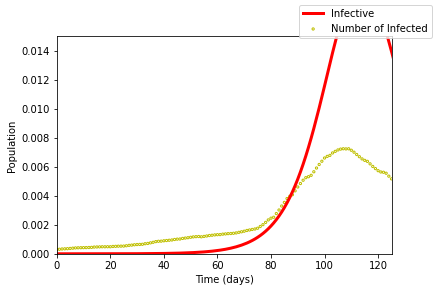

In [ ]:

#initial conditions
N = 3186989
I0 = 1/N
S0 = 1. - I0
R0 = 0.
x0 = [S0, I0, R0]

def wave_infected(a, k, wave):
  #declare a time vector (time window)
  size1 = wave.shape[0]
  t = np.linspace(0, size1-1, size1)
  #x = odeint(odes,x0,t, args=((1/2.5)+(0.01/2), (1/3)-0.01))

  #Experimental
  x = odeint(odes,x0,t, args=(a, k))

  S = x[:,0]
  I = x[:,1]
  R = x[:,2]

  to_plot = wave['Number of Infected'].to_numpy().copy()
  to_plot /= N

  print("Max Infected peak: ", max(I))
  fig1 = plt.figure(1); fig1.clf()
  #plt.plot(t, S, 'g', lw=3, label='Suseptible')
  plt.plot(t, I, 'r', lw=3, label='Infective')
  #plt.plot(t, R, 'b', lw=3, label='Removed')
  # plt.plot(t, y1[0], 'y', lw=3, label='Total Infected for 7-day Avg')
  # plt.plot(t, y1[1], 'b', lw=3, label='Total Infected for 28-day Avg')
  # plt.plot(t, y2[2], 'black', lw=3, label='Total Infected')
  plt.scatter(t, to_plot, s=5, facecolors='none', edgecolors='y', label='Number of Infected')
  plt.axis([0, 125, 0, 0.015])

  fig1.legend()
  plt.xlabel('Time (days)')
  plt.ylabel('Population')

  return S, I, R

const = 1.9
a = (1/3.25) * const
k = (1/4) * const

S, I, R = wave_infected(a, k, df_wave1)
R0 = a/k
print("a = ", a)
print("k = ", k)
print("Rate = ", 1/a)
print("Period = ", 1/k)
print("R0 = ", R0)

In [ ]:
df_wave2

Max Infected peak:  0.25035150487453306
a =  0.2857142857142857
k =  0.10909090909090909
Rate =  3.5
k =  9.166666666666668
R0 =  2.619047619047619


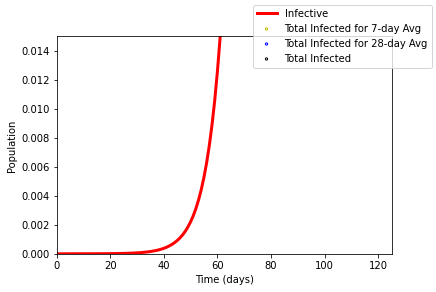

In [ ]:
const = 1.2
a, k = const * 1/4.2, const * 1/11
S, I, R = wave1(a, k, df_wave2)
R0 = a/k
print("a = ", a)
print("k = ", k)
print("Rate = ", 1/a)
print("k = ", 1/k)
print("R0 = ", R0)

# Wave 1, Wave 2, Wave 3, Wave 4 (Daily Cases)

In [ ]:
from uuid import NAMESPACE_OID

#initial conditions
N = 3186989
I0 = 1/N
S0 = 1. - I0
R0 = 0.
x0 = [S0, I0, R0]

def daily_wave(a, k, wave):
  #declare a time vector (time window)
  size1 = wave.shape[0] + 120
  t = np.linspace(0, size1-1, size1)
  #x = odeint(odes,x0,t, args=((1/2.5)+(0.01/2), (1/3)-0.01))

  #Experimental
  x = odeint(odes,x0,t, args=(a, k))

  S = x[:,0]
  I = x[:,1]
  R = x[:,2]

  y1_a = wave['7-day Avg'].to_numpy().copy()
  y1_a /= N
  y1_a = list(y1_a)
  y1_a = [0.0 for i in range(60)] + y1_a + [0.0 for i in range(60)]

  y1_b = wave['28-day Avg'].to_numpy().copy()
  y1_b /= N
  y1_b = list(y1_b)
  y1_b = [0.0 for i in range(60)] + y1_b + [0.0 for i in range(60)]

  y1_c = wave['Infected per day'].to_numpy().copy()
  y1_c.astype(float)
  y1_c /= N
  y1_c = list(y1_c)
  y1_c = [0.0 for i in range(60)] + y1_c + [0.0 for i in range(60)]
  print(y1_c)

  y1 = np.array([y1_a, y1_b, y1_c])

  print("Max Infected peak: ", max(I))
  fig1 = plt.figure(1); fig1.clf()
  #plt.plot(t, S, 'g', lw=3, label='Suseptible')
  #plt.plot(t, I, 'r', lw=3, label='Infective')

  # I = list(I)
  # I = [0 for i in range(60)] + I + [0 for i in range(60)]
  # print(I)
  # t = list(t)
  # t = [(i+0.0) for i in range(60)] + [(60.0+i) for i in t] + [(i+183.0+60.0) for i in range(60)]

  print(t)
  plt.plot(t, I, 'r', lw=3, label='Infective')
  #plt.plot(t, R, 'b', lw=3, label='Removed')
  # plt.plot(t, y1[0], 'y', lw=3, label='Total Infected for 7-day Avg')
  # plt.plot(t, y1[1], 'b', lw=3, label='Total Infected for 28-day Avg')
  # plt.plot(t, y2[2], 'black', lw=3, label='Total Infected')
  plt.scatter(t, y1[0], s=5, facecolors='none', edgecolors='y', label='Total Infected for 7-day Avg')
  plt.scatter(t, y1[1], s=5, facecolors='none', edgecolors='b', label='Total Infected for 28-day Avg')
  plt.scatter(t, y1[2], s=5, facecolors='none', edgecolors='black', label='Total Infected')
  # plt.axis([0, 125, 0, 0.015])

  fig1.legend()
  plt.xlabel('Time (days)')
  plt.ylabel('Population')

  return S, I, R

Rate =  17.0
Period =  21.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.290563287165409e-05, 1.6002565430881624e-05, 2.0081650736792627e-05, 9.09949799010916e-06, 1.0040825368396313e-05, 1.6630117016406396e-05, 1.8512771772980703e-05, 1.7571444394693548e-05, 1.4433686467069702e-05, 1.4433686467069702e-05, 7.84439481905962e-06, 5.961740062485312e-06, 1.7885220187455934e-05, 2.1964305493366937e-05, 3.0122476105188942e-05, 2.2591857078891705e-05, 2.2591857078891705e-05, 1.2551031710495392e-05, 7.84439481905962e-06, 2.1964305493366937e-05, 2.1964305493366937e-05, 3.859442250977333e-05, 2.541583921375317e-05, 2.7612269763089863e-05, 1.819899598021832e-05, 1.4747462259832086e-05, 4.047707726634764e-05, 5.1773005805793496e-05, 3.953574988

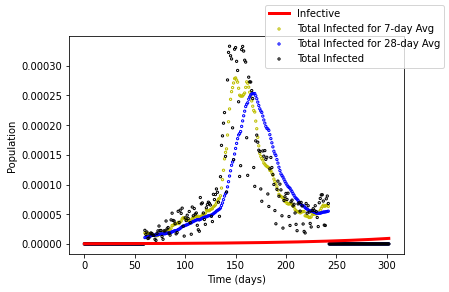

In [ ]:
a, k = 1/17, 1/21
print("Rate = ", 1/a)
print("Period = ", 1/k)
S, I, R = daily_wave(a, k, df_wave1)

Rate =  99999.99999999999
Period =  99999.99999999999
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.150005538142742e-05, 6.40102617235265e-05, 3.5456664582149485e-05, 2.8239821348614632e-05, 6.714801965115035e-05, 7.091332916429897e-05, 7.028577757877419e-05, 7.62475176412595e-05, 6.244138275971458e-05, 4.33010594012091e-05, 2.6670942384802708e-05, 7.059955337153659e-05, 7.969905136164574e-05, 7.059955337153659e-05, 7.185465654258612e-05, 6.683424385838797e-05, 4.4242386779496256e-05, 3.608421616767425e-05, 8.503323983860629e-05, 8.377813666755674e-05, 9.570161679252737e-05, 7.656129343402189e-05, 7.342353550639805e-05, 5.1459230013031106e-05, 3.671176775319902e-05, 8.189548191098243e-05, 6.0244952210377884e-05, 8.942610093727967e-05

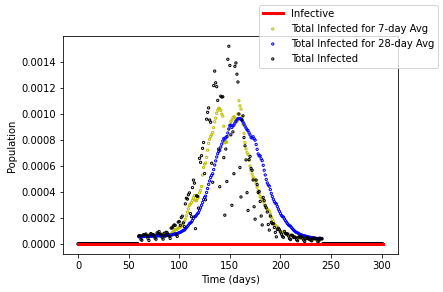

In [ ]:
a, k = 0.00001, 0.00001
print("Rate = ", 1/a)
print("Period = ", 1/k)
S, I, R = daily_wave(a, k, df_wave2)

Rate =  99999.99999999999
Period =  99999.99999999999
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.5142888789387096e-05, 3.7339319338723795e-05, 2.0081650736792627e-05, 1.03546011611587e-05, 3.796687092424856e-05, 5.428321214789257e-05, 6.306893434523935e-05, 7.21684323353485e-05, 5.742097007551642e-05, 5.8676073246565956e-05, 4.361483519397149e-05, 8.754344618070536e-05, 0.0001051148905753989, 9.883937472015121e-05, 0.00011076285484512183, 9.821182313462644e-05, 7.279598392087328e-05, 8.189548191098243e-05, 0.00013398226350953832, 0.00015469146583185571, 0.00016441851540748963, 0.00016630117016406396, 0.00018261751138770797, 0.00012456898972666676, 0.0001277067476542906, 0.0002230945886540556, 0.00020740579901593637, 0.000242234912

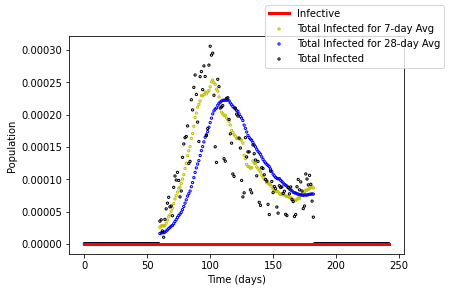

In [ ]:
a, k = 0.00001, 0.00001
print("Rate = ", 1/a)
print("Period = ", 1/k)
S, I, R = daily_wave(a, k, df_wave3)

In [ ]:
#intersets at about t=124
N2 = int(S[126] * N)
N2

3186987

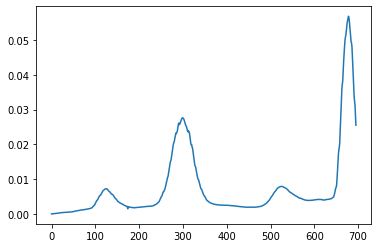

In [ ]:
t = np.linspace(0, df_new.shape[0] - 1, df_new.shape[0])
to_plot = df_new['Number of Infected'].to_numpy().copy()
to_plot /= N
plt.plot(t, to_plot)

In [ ]:
np.log(np.exp(2))
d = (1/120) * np.log(N*y1_a[120])
test_k = 1/3
test_a = test_k + d
print(test_a)
print(test_k)

NameError: ignored

In [ ]:
#higher a-value means higher peak but shorter pandemic
#higher k-value means lower peak but longer pandemic

In [ ]:
def wave2(a, k):
  size2 = df_wave2.shape[0]
  t = np.linspace(0, size2-1, size2)
  x = odeint(odes,x0,t, args=(a, k))

  S = x[:,0]
  I = x[:,1]
  R = x[:,2]

  y2_a = df_wave2['Total Infected for 7-day Avg'].to_numpy().copy()
  y2_a /= N2
  y2_b = df_wave2['Total Infected for 28-day Avg'].to_numpy().copy()
  y2_b /= N2
  y2_c = df_wave2['Total Infected'].to_numpy().copy()
  y2_c.astype(float)
  y2_c /= N2
  y2 = np.array([y2_a, y2_b, y2_c])

  fig2 = plt.figure(1); fig2.clf()
  #plt.plot(t, S, 'g', lw=3, label='Suseptible')
  plt.plot(t, I, 'r', lw=3, label='Infective')
  #plt.plot(t, R, 'b', lw=3, label='Removed')
  plt.plot(t, y2[0], 'y', lw=3, label='7-day Avg')
  plt.plot(t, y2[1], 'brown', lw=3, label='28-day Avg')
  plt.plot(t, y2[2], 'm', lw=3, label='Raw Data')

  fig2.legend()
  plt.xlabel('Time (days)')
  plt.ylabel('Population')

  return S, I, R

const = 0.35
a = 0.7*const
k = 0.3333333333333333*const
S, I, R = wave2(a, k)
R0 = a/k
print("a = ", a)
print("k = ", k)
print("R0 = ", R0)
print("Max = ", max(I))

NameError: ignored

In [ ]:
d = (1/50) * np.log(N*y2_a[50])
test_k = 1/3
test_a = test_k + d
print(test_a)
print(test_k)

In [ ]:
fig1 = plt.figure(1); fig1.clf()
#plt.plot(t, S, 'g', lw=3, label='Suseptible')
plt.plot(t, I, 'r', lw=3, label='Infective')
#plt.plot(t, R, 'b', lw=3, label='Removed')
plt.plot(t, y1[0], 'y', lw=3, label='7-day Avg')
plt.plot(t, y1[1], 'brown', lw=3, label='28-day Avg')
plt.plot(t, y1[2], 'm', lw=3, label='Raw Data')

fig1.legend()
plt.xlabel('Time (days)')
plt.ylabel('Population')

In [ ]:
t = np.linspace(0, 10)
x = odeint(odes,x0,t, args=(6,1.4))

S = x[:,0]
I = x[:,1]
R = x[:,2]

print(max(I))
fig = plt.figure(1); fig.clf()
plt.plot(t, S, 'g', lw=3, label='Suseptible')
plt.plot(t, I, 'r', lw=3, label='Infective')
plt.plot(t, R, 'b', lw=3, label='Removed')

fig.legend()
plt.xlabel('Time (days)')
plt.ylabel('Population')

In [ ]:
print(max(I))
print(max(y1[0]))